In [1]:
# import jax.numpy as np
# import numpy as tnp
from prysm.mathops import np,fft
import matplotlib.pyplot as plt
import prysm
prysm.__version__

'0.19.2.dev422+gfb77e89'

In [2]:
# SIMULATION PARAMETERS
EFL = 131.4e3 # milimeters
EPD = 6.510e3 # milimeters
WVL = 0.656   # microns
OS = 6
IMG_NPIX = 1024

# Dark Hole
IWA = 2.5
OWA = 12
AZMIN = -60
AZMAX = 60

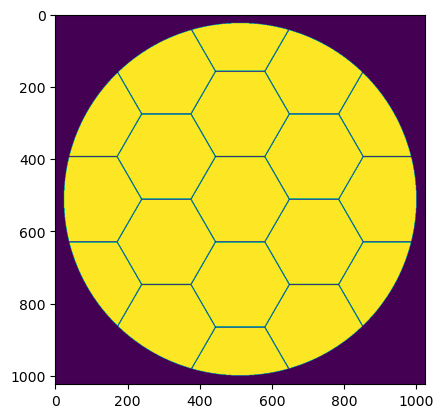

In [3]:
from astropy.io import fits

# Load Aperture
circle_mask = fits.getdata('/Users/jashcraft/Downloads/hex_pupil_amplitude_6510mm_1024pix.fits')
plt.imshow(circle_mask)
PUPIL_NPIX = circle_mask.shape[0]

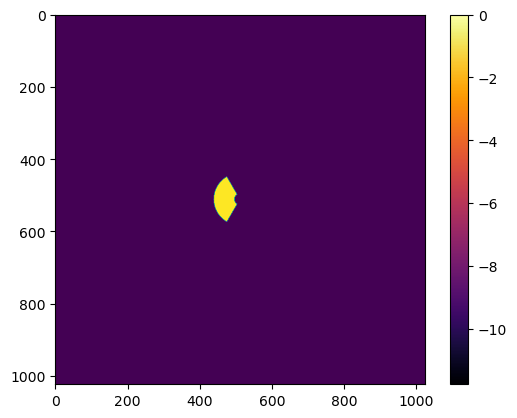

In [4]:
from prysm.propagation import focus_fixed_sampling,focus_fixed_sampling_backprop
from prysm import coordinates, geometry

img_dx = WVL * (EFL / EPD) / OS
pupil_dx = EPD / PUPIL_NPIX
# now set up the focal plane mask
psf = focus_fixed_sampling(wavefunction=circle_mask,
                           input_dx=pupil_dx,
                           prop_dist=EFL,
                           wavelength=WVL,
                           output_dx=img_dx,
                           output_samples=IMG_NPIX)

from dygdug.models import ImgSamplingSpec, one_sided_annulus

lambd = EFL / EPD * WVL  # um
iss = ImgSamplingSpec(IMG_NPIX, lambd / OS, lambd)  # 10/lambd
dh = one_sided_annulus(iss, IWA,
                            OWA, 
                            AZMIN,
                            AZMAX)
dh = np.fliplr(dh)
psf_I = np.abs(psf)**2
plt.imshow(dh * np.log10(psf_I/psf_I.max()+1e-16),cmap='inferno')
plt.colorbar()

# create the core mask
def inner_core_mask(iss, iwa):

    x, y = coordinates.make_xy_grid(iss.N, dx=iss.dx)
    r, t = coordinates.cart_to_polar(x, y)
    iwa = iwa * iss.lamD
    mask = geometry.circle(iwa, r)

    return mask

def knife_edge_mask(iss, iwa):
    x, y = coordinates.make_xy_grid(iss.N, dx=iss.dx)
    iwa = iwa * iss.lamD
    mask = x > iwa

    return mask

def lyot_mask(pupil_npix, pupil_dx, frac):

    x, y = coordinates.make_xy_grid(pupil_npix, dx=pupil_dx)
    r, t = coordinates.cart_to_polar(x, y)
    rnorm = r / (r.max() * np.sqrt(2))
    ls = np.zeros_like(x)
    ls[rnorm < frac/2] = 1

    return ls


# mask transmits inner 1.5 L/D
inner_mask = inner_core_mask(iss, 1.5)
knife_mask = knife_edge_mask(iss, IWA)
ls_mask = lyot_mask(circle_mask.shape[0], pupil_dx=pupil_dx, frac=0.85)
plt.imshow(dh)

In [5]:
from dygdug.vappid import APLCOptimizer2

aplc = APLCOptimizer2(amp=circle_mask,
                      amp_dx=pupil_dx,
                      efl=EFL, 
                      wvl=WVL, 
                      basis=None, 
                      dark_hole=dh,
                      dh_target=0,
                      dh_dx=img_dx,
                      fpm=knife_mask,
                      ls=ls_mask)

aplc.set_optimization_method(zonal=True)
print(aplc.zonal)

# make sure these work'
aplc.fwd(np.random.random(aplc.amp[aplc.amp_select].shape))
aplc.rev(np.random.random(aplc.amp[aplc.amp_select].shape))

True


array([-3.57187976e-05, -3.65412803e-05, -3.67917283e-05, ...,
       -3.77517256e-05, -3.74280429e-05, -3.65786321e-05])

In [6]:
from prysm.x.optym import F77LBFGSB

x0 = np.ones(aplc.amp.shape, dtype=float)[aplc.amp_select]
x0 = np.ascontiguousarray(x0)
opt = F77LBFGSB(aplc.fg, x0, memory=10, upper_bounds=np.ones(x0.shape), lower_bounds=np.zeros(x0.shape))
opt.iprint = 0

for _ in range(1000):
    opt.step()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       732197     M =           10


/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_75935/4257821676.py:4: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.imag(aplc.bbar * aplc.b.conj())/aplc.amp,cmap='RdBu_r')


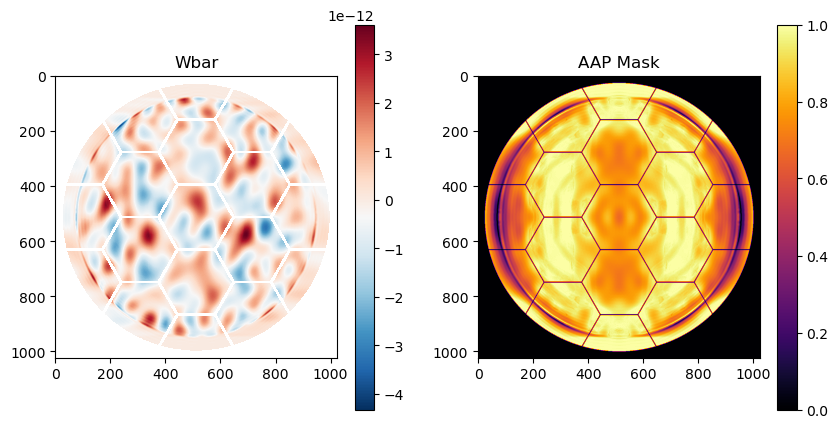

In [13]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Wbar')
plt.imshow(np.imag(aplc.bbar * aplc.b.conj())/aplc.amp,cmap='RdBu_r')
plt.colorbar()
plt.subplot(122)
plt.title('AAP Mask')
plt.imshow(aplc.aplc,cmap='inferno') 
plt.colorbar()
plt.show()

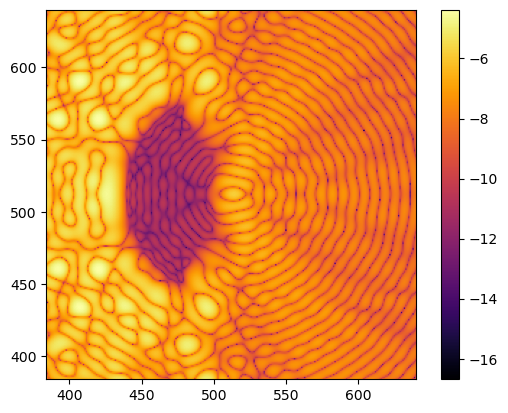

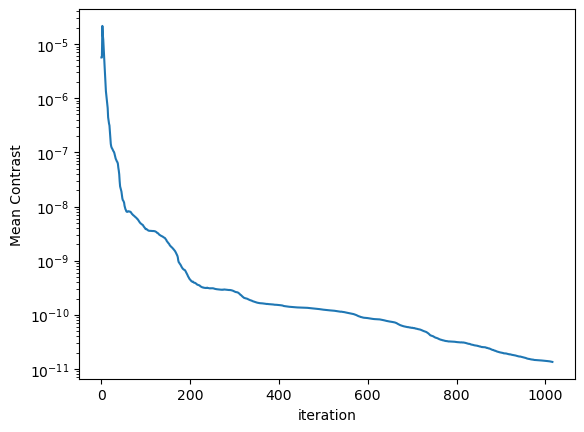

In [14]:
cut = 128
contrast_norm = np.abs(aplc.B)**2
contrast_norm = contrast_norm.max()
plt.imshow(np.log10(aplc.I/contrast_norm) ,cmap='inferno')
plt.xlim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.ylim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.colorbar()
plt.show()

plt.plot(aplc.cost/contrast_norm)
plt.ylabel('Mean Contrast')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

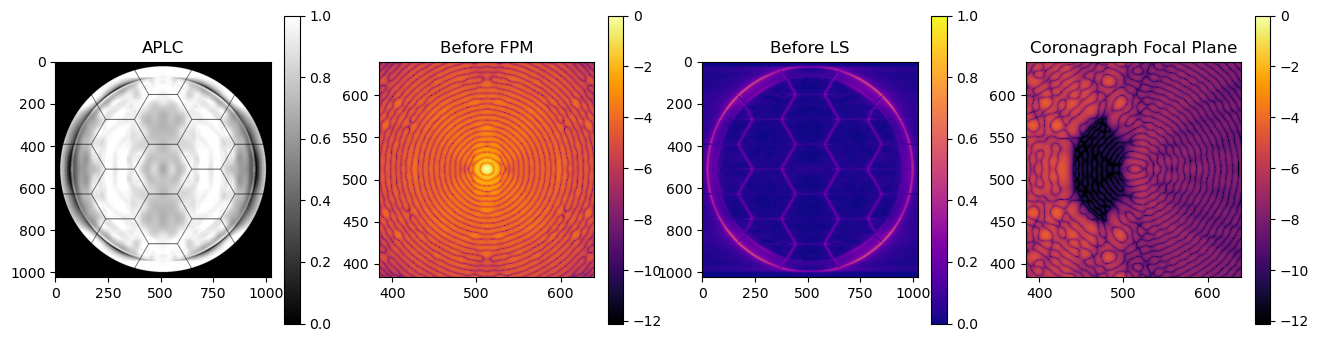

In [15]:
focal_field_irrad = np.abs(aplc.B)**2

data = [aplc.aplc, # apodizer
        np.log10(focal_field_irrad /focal_field_irrad.max()), # field before FPM
        np.abs(aplc.c), # field before LS
        np.log10(aplc.I/focal_field_irrad.max())] # field at coronagraph focal plane

titles = ['APLC','Before FPM','Before LS','Coronagraph Focal Plane']
cmaps = ['gray','inferno','plasma','inferno']

vmins = [0,0,0,0]
vmaxs = [1,-11,1,-11]

lim = [None,128,None,128]

plt.figure(figsize=[16,4])
for i,(d,tit,vmin,vmax,cut,cmap) in enumerate(zip(data,titles,vmins,vmaxs,lim,cmaps)):
    plt.subplot(1,4,i+1)
    plt.title(tit)
    plt.imshow(d,cmap=cmap,vmin=vmin,vmax=vmax)
    if i == 1 or i == 3:
        plt.xlim(d.shape[0]/2 - cut,d.shape[0]/2 + cut)
        plt.ylim(d.shape[0]/2 - cut,d.shape[0]/2 + cut)
    plt.colorbar() 
plt.show()

In [16]:
np.sum(aplc.aplc)/np.sum(circle_mask)

0.8287855129443662

In [109]:
tilts = [0]# np.arange(0,13,1)
psf_energy = []
for TILT_WAVES in tilts:
    TILT_WAVES *= -1
    xx, yy = coordinates.make_xy_grid(aplc.aplc.shape,dx=pupil_dx)
    tilt_aberr = np.exp(-1j * np.pi * xx / xx.max()  * TILT_WAVES)

    before_fpm = focus_fixed_sampling(
                wavefunction=aplc.aplc * tilt_aberr,
                input_dx=pupil_dx,
                prop_dist = EFL,
                wavelength= WVL,
                output_dx= img_dx,
                output_samples=dh.shape,
                shift=(0, 0),
                method='mdft')

    before_ls = focus_fixed_sampling(
                wavefunction=before_fpm * knife_mask,
                input_dx=img_dx,
                prop_dist = EFL,
                wavelength= WVL,
                output_dx= pupil_dx,
                output_samples=aplc.aplc.shape,
                shift=(0, 0),
                method='mdft')

    coro_img_onax = focus_fixed_sampling(
                wavefunction=before_ls * ls_mask,
                input_dx=pupil_dx,
                prop_dist = EFL,
                wavelength= WVL,
                output_dx= img_dx,
                output_samples=dh.shape,
                shift=(0, 0),
                method='mdft')
    
    I = np.abs(coro_img_ofax)**2 / contrast_norm.max()
    psf_energy.append(np.sum(I))

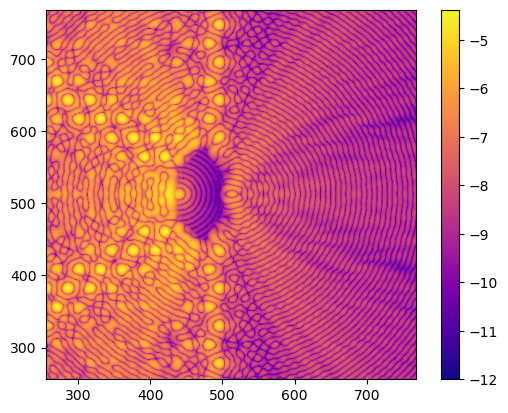

In [108]:
cut = 256
plt.style.use('default')
psf_sum = np.abs(coro_img_onax)**2 + 1e-5 * np.abs(coro_img_ofax)**2
before_fpm_irrad = np.abs(before_fpm)**2
plt.imshow(np.log10(psf_sum/contrast_norm), vmin=-12, cmap='plasma')
plt.xlim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.ylim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.colorbar()

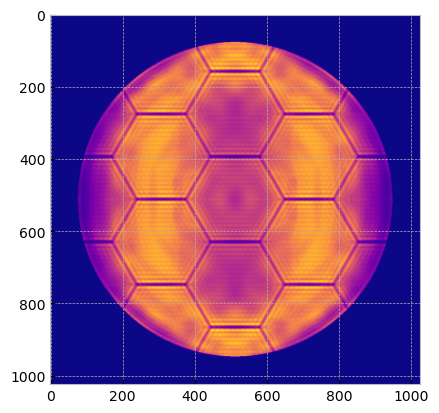

In [107]:
plt.imshow(np.abs(before_ls)**2 * ls_mask,cmap='plasma')

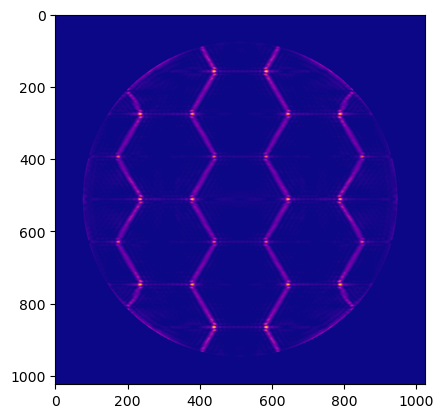

In [110]:
plt.imshow(np.abs(before_ls)**2 * ls_mask,cmap='plasma')

In [102]:
np.sum(aplc.aplc) / np.sum(circle_mask)

0.8287855129443662

(0.0, 12.5)

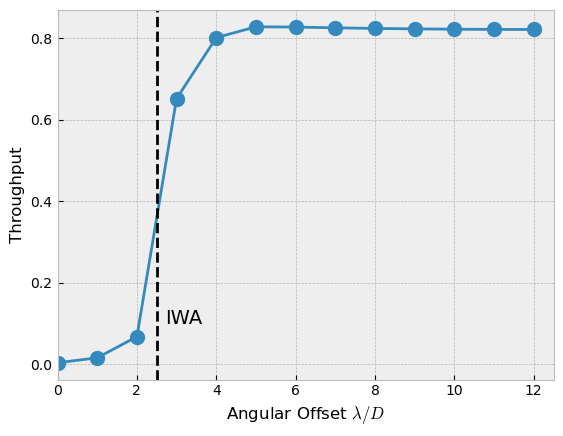

In [105]:
plt.style.use('bmh')
plt.plot(tilts,psf_energy/(np.sum(focal_field_irrad)/contrast_norm),marker='o',markersize=10)
plt.axvline(2.5, color='black', linestyle='dashed')
plt.ylabel('Throughput')
plt.xlabel('Angular Offset '+r'$\lambda / D$')
plt.text(2.7,0.1,s='IWA',fontsize=14)
plt.xlim(0,12.5)